In [1]:
import pandas as pd
import glob
import os
from utils import util
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np

In [2]:
def get_complementarity_table(run_name1, run_name2, epoch, target_emo, legend_list=None):
    root_dir = '/mnt/iot-qnap3/mochida/medical-care/emotionestimation/reports/PIMD_A/'
    pred_df = pd.DataFrame()
    comp_table = pd.DataFrame(np.zeros((4,4)), index=['TP', 'FP', 'FN', 'TN'], columns=['TP', 'FP', 'FN', 'TN'])
    path_list_dict = {
        'TP':{'TP':[], 'FP':[], 'FN':[], 'TN':[]},
        'FP':{'TP':[], 'FP':[], 'FN':[], 'TN':[]}, 
        'FN':{'TP':[], 'FP':[], 'FN':[], 'TN':[]}, 
        'TN':{'TP':[], 'FP':[], 'FN':[], 'TN':[]}
    }
    if epoch is not None:
        target_dir1 = root_dir + run_name1 + f'/epoch{epoch[0]}/'
        target_dir2 = root_dir + run_name2 + f'/epoch{epoch[1]}/'
    else:
        target_dir1 = root_dir + run_name1
        target_dir2 = root_dir + run_name2
        
    df1 = pd.DataFrame()
    df2 = pd.DataFrame()
        
    csv_path_list1 = glob.glob(os.path.join(target_dir1, "**/", f"*_pred.csv"), recursive=True)
    for csv_path in csv_path_list1:
        _df = pd.read_csv(csv_path)
        df1 = pd.concat([df1, _df])
    df1 = df1.reset_index(drop=True)
    df1['video_name'], df1['frame_num'] = zip(*df1['img_path'].map(util.get_video_name_and_frame_num))
    
    csv_path_list2 = glob.glob(os.path.join(target_dir2, "**/", f"*_pred.csv"), recursive=True)
    for csv_path in csv_path_list2:
        _df = pd.read_csv(csv_path)
        df2 = pd.concat([df2, _df])
    df2 = df2.reset_index(drop=True)
    df2['video_name'], df2['frame_num'] = zip(*df2['img_path'].map(util.get_video_name_and_frame_num))
    
    pred_df['emo_gt'] = df1['emo_gt']
    pred_df['img_path'] = df1['img_path']
    pred_df['emo_pred1'] = df1['emo_pred']
    pred_df['emo_pred2'] = df2['emo_pred']
    
    gt_list = []
    if target_emo == "comfort":
        # copy pred["emo_gt"] to gt_list
        gt_list = pred_df["emo_gt"].copy()
        # replace 2 to 0
        gt_list = gt_list.replace(2, 0)
    elif target_emo == "discomfort":
        # copy pred["emo_gt"] to gt_list
        gt_list = pred_df["emo_gt"].copy()
        # replace 1 to 0
        gt_list = gt_list.replace(1, 0)
        # replace 2 to 1
        gt_list = gt_list.replace(2, 1)
    
    # fill complementarity table
    for i in range(len(pred_df)):
        pred1 = None
        pred2 = None
        if pred_df['emo_pred1'][i] == 1 and gt_list[i] == 1:
            if pred_df['emo_pred2'][i] == 1:
                pred1 = 'TP'
                pred2 = 'TP'
            else:
                pred1 = 'TP'
                pred2 = 'FN'
        
        elif pred_df['emo_pred1'][i] == 1 and gt_list[i] == 0:
            if pred_df['emo_pred2'][i] == 1:
                pred1 = 'FP'
                pred2 = 'FP'
            else:
                pred1 = 'FP'
                pred2 = 'TN'
                
        elif pred_df['emo_pred1'][i] == 0 and gt_list[i] == 1:
            if pred_df['emo_pred2'][i] == 1:
                pred1 = 'FN'
                pred2 = 'TP'
            else:
                pred1 = 'FN'
                pred2 = 'FN'
                
        elif pred_df['emo_pred1'][i] == 0 and gt_list[i] == 0:
            if pred_df['emo_pred2'][i] == 1:
                pred1 = 'TN'
                pred2 = 'FP'
            else:
                pred1 = 'TN'
                pred2 = 'TN'
                
        comp_table[pred1][pred2] += 1
        path_list_dict[pred1][pred2].append(pred_df['img_path'][i])
                
    # show complementarity table as heatmap
    sns.heatmap(comp_table, annot=True, fmt='g', cmap='Blues', square=True, vmax=len(pred_df))
    # show parsentage
    
    # x_label
    X_label = run_name1
    if legend_list is not None:
        X_label = legend_list[0]
    plt.xlabel(X_label, fontsize=15)
    
    # y_label
    Y_label = run_name2
    if legend_list is not None:
        Y_label = legend_list[1]
    plt.ylabel(Y_label, fontsize=15) 
    
    plt.title(f'{X_label} vs {Y_label} ({target_emo})', fontsize=15)
    
    return path_list_dict

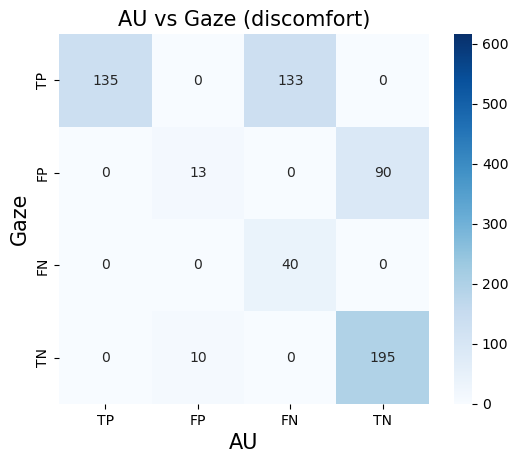

In [3]:
# discomfort AU vs gaze
run_name1 = '4_d_a'
run_name2 = '4_d_g'
epoch = [10, 10]
path_list = get_complementarity_table(run_name1, run_name2, epoch, "discomfort", legend_list=['AU', 'Gaze'])

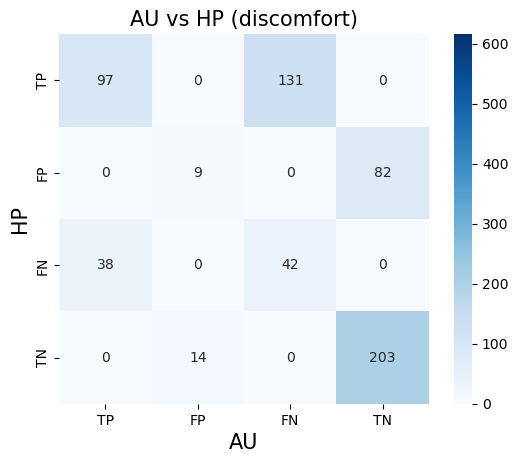

In [4]:
# discomfort AU vs HP
run_name1 = '4_d_a'
run_name2 = '4_d_h'
epoch = [10, 5]

path_list = get_complementarity_table(run_name1, run_name2, epoch, "discomfort", legend_list=['AU', 'HP'])

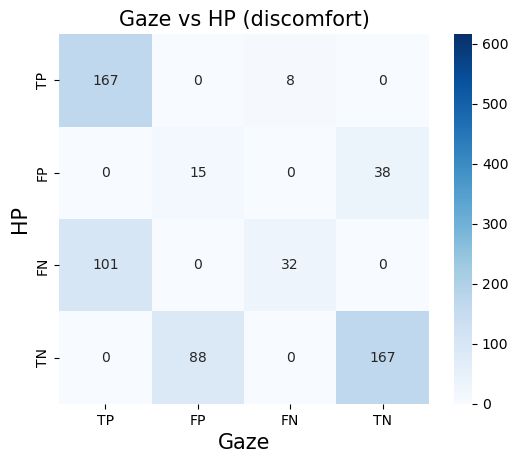

In [6]:
# discomfort gaze vs HP
run_name1 = '4_d_g'
run_name2 = '4_d_h'
epoch = [10, 10]

path_list = get_complementarity_table(run_name1, run_name2, epoch, "discomfort", legend_list=['Gaze', 'HP'])

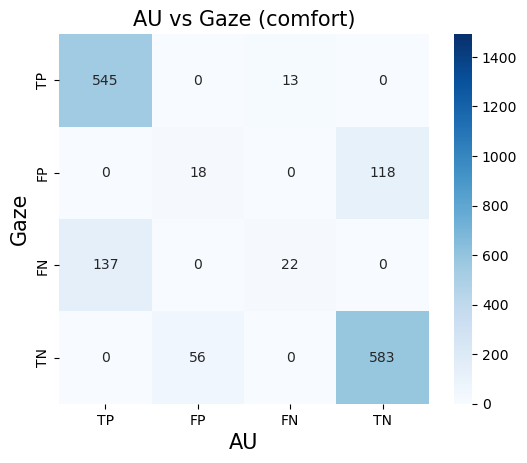

In [26]:
#comfort AU vs gaze
run_name1 = '2-1_c_a_mean-feats_ws30-ss5'
run_name2 = '2-2_c_g_womp-logits-nch2_ws30-ss5'
epoch = [3, 10]
get_complementarity_table(run_name1, run_name2, epoch, "comfort", legend_list=['AU', 'Gaze'])

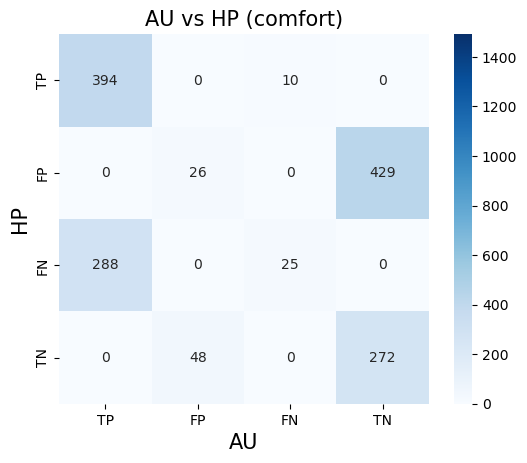

In [27]:
#comfort AU vs HP
run_name1 = '2-1_c_a_mean-feats_ws30-ss5'
run_name2 = '2-2_c_h_womp-logits-nch2_ws30-ss5'
epoch = [3, 10]
get_complementarity_table(run_name1, run_name2, epoch, "comfort", legend_list=['AU', 'HP'])

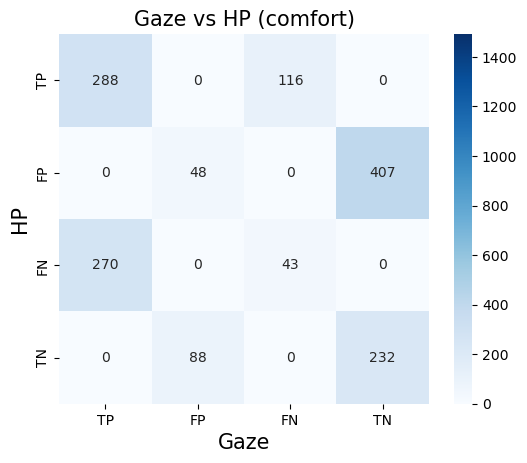

In [28]:
#comfort gaze vs HP
run_name1 = '2-2_c_g_womp-logits-nch2_ws30-ss5'
run_name2 = '2-2_c_h_womp-logits-nch2_ws30-ss5'
epoch = [10, 10]

get_complementarity_table(run_name1, run_name2, epoch, "comfort", legend_list=['Gaze', 'HP'])